# Prudentia WebRTC Extension

## Google Meets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import re
from datetime import datetime, timedelta
from collections import deque

In [2]:
blue = sns.color_palette('muted')[0]
orange = sns.color_palette('muted')[1]
green = sns.color_palette('muted')[2]

In [3]:
plt.rc('figure', figsize=(10, 6))
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=18)
plt.rc('font', size=14)

In [4]:
def parse_file(path, start, end):
    start_timestamp = None
    elapseds = []
    lengths = []
    types = []
    
    pattern = r'^(\d{2}:\d{2}:\d{2}\.\d{6}).*payload length: (\d+).* (c\d+)'
    i = 0
    with open(path, "r") as file:
        for idx, line in enumerate(file):
            line = line.strip()
            match = re.search(pattern, line)
            if match:    
                timestamp_str = match.group(1)
                length = int(match.group(2))
                type = match.group(3)
                timestamp = datetime.strptime(timestamp_str, "%H:%M:%S.%f")
                if not start_timestamp:
                    start_timestamp = timestamp
                elapsed = (timestamp - start_timestamp).total_seconds()
                if start <= elapsed < end:
                    elapseds.append(elapsed)
                    lengths.append(length)
                    types.append(type)
                if end < elapsed:
                    break

    return ([e - start for e in elapseds], lengths, types)

In [5]:
start = 180
duration = 60
end = start + duration
sender = np.stack(parse_file("sender", start, end), axis=1)
receiver = np.stack(parse_file("receiver", start, end), axis=1)
max_packet_length = np.max(np.concatenate((receiver[:, 1], sender[:, 1])).astype(int))

In [6]:
unique_types = np.unique(np.concatenate((receiver[:, 2], sender[:, 2]), axis=0))
color_map = cm.rainbow(np.linspace(0, 1, len(unique_types)))
def scatter(data, title, ax, dur=duration):
    elapsed_times, lengths, types = data[:, 0].astype(float), data[:, 1].astype(int), data[:, 2]
    for i, t in enumerate(unique_types):
        mask = types == t
        elapsed = elapsed_times[mask]
        packet_length = lengths[mask]
        ax.scatter(elapsed, packet_length, color=color_map[i], s=3)
    
    ax.set_title(title + ": " + str(len(data)))
    ax.set_xlim(0, dur)
    ax.set_ylim(0, max_packet_length + 75)

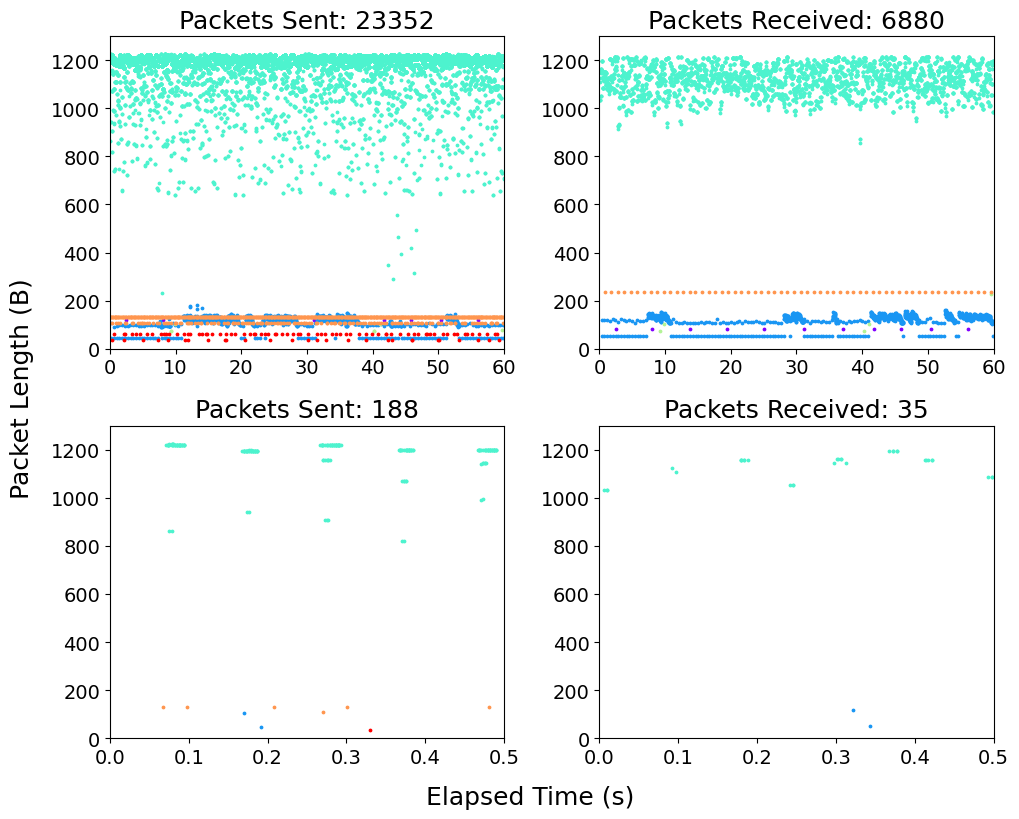

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

scatter(sender, "Packets Sent", ax[0][0])
scatter(receiver, "Packets Received", ax[0][1])

dur = 0.5
sender_short = sender[sender[:, 0].astype(float) < dur]
receiver_short = receiver[receiver[:, 0].astype(float) < dur]

scatter(sender_short, "Packets Sent", ax[1][0], dur=dur)
scatter(receiver_short, "Packets Received", ax[1][1], dur=dur)

fig.text(0.5, -0.02, 'Elapsed Time (s)', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'Packet Length (B)', va='center', rotation='vertical', fontsize=18)

plt.tight_layout()
plt.show()

In [8]:
video_type = "c120" # Get video type
sender_comm = sender[sender[:, 2] == video_type]
receiver_comm = receiver[receiver[:, 2] == video_type]

In [9]:
def stats(data, title, ax):
    elapsed_time, lengths = data[:, 0].astype(float), data[:, 1].astype(int)
    
    unique_lengths, counts = np.unique(lengths, return_counts=True)
    pmf = counts / len(lengths)
    
    sorted_lengths = np.sort(unique_lengths)
    cdf = np.cumsum(pmf)
    
    ax[0].bar(unique_lengths, pmf, width=10, color=blue)
    ax[0].set_title(title + ": Video PMF")
    ax[0].set_xlim(600, max_packet_length + 10) # Warning: Hardcode!
    ax[0].set_ylim(0, 0.033) # Warning: Hardcode!

    ax[1].step(sorted_lengths, cdf, where='mid', color=orange)
    ax[1].set_title(title + ": Video CDF")
    ax[1].set_xlim(600, max_packet_length + 10) # Warning: Hardcode!
    ax[1].set_ylim(0, 1)

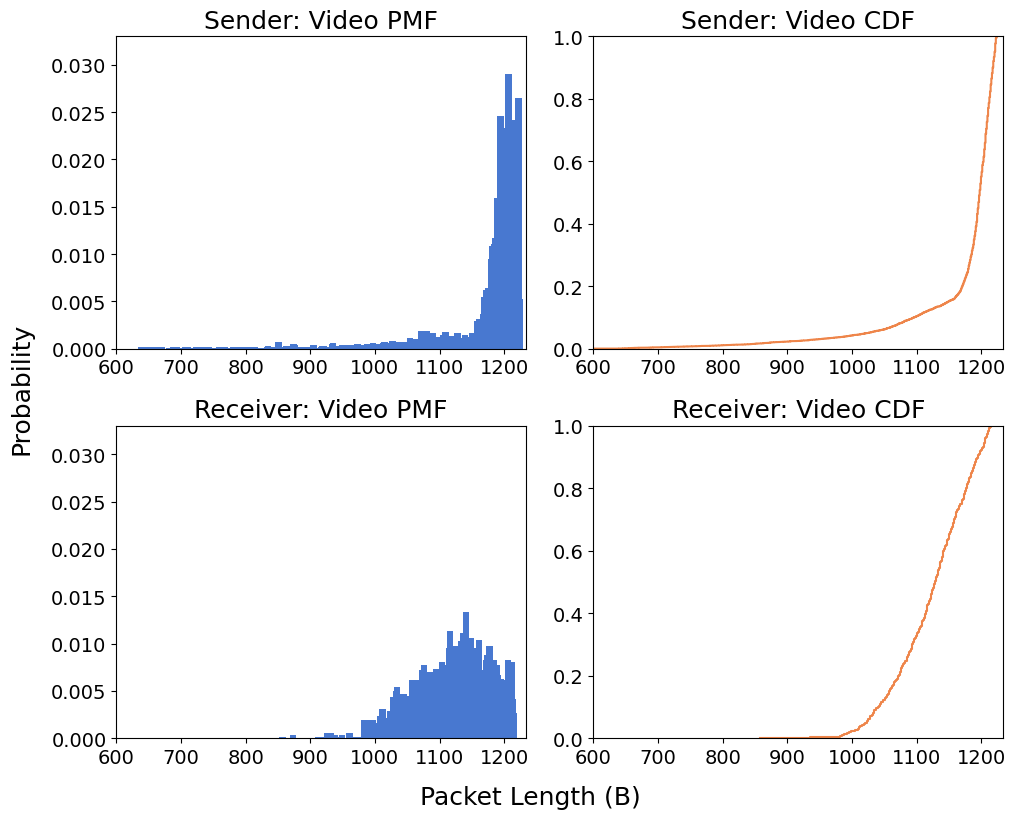

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

stats(sender_comm, "Sender", ax[0])
stats(receiver_comm, "Receiver", ax[1])

fig.text(0.5, -0.02, 'Packet Length (B)', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'Probability', va='center', rotation='vertical', fontsize=18)

plt.tight_layout()
plt.show()

## UDP/IP: QoE Heuristic Inference 

In [11]:
video_cutoff = 800 # Heuristic to get video frames without inspecting rtp header
delta_max = 2 # H
N_max = 3
def frames_heuristic(data):
    f = 0
    prev = deque()
    frames = []
    for p in packets:
        assigned = False
        for idx, pre in enumerate(list(prev)[::-1]):
            if abs(pre[1].astype(int) - p[1].astype(int)) <= delta_max: # Old frame
                frames.append(frames[-(1 + idx)])
                assigned = True
                break
        if not assigned:
            f += 1
            frames.append(f)
            
        if len(prev) == N_max:
            prev.popleft();
        prev.append(p)
    
    return frames

In [12]:
packets = receiver[receiver[:, 1].astype(int) >= video_cutoff]

frames = frames_heuristic(packets[packets[:, 1].astype(int) >= video_cutoff])
elapsed = packets[:, 0].astype(float)
size = packets[:, 1].astype(int)

In [13]:
def get_times(frames, elapsed):
    times = []
    for idx, f in enumerate(frames):
        no_see = 0
        t = elapsed[idx]
        jdx = idx + 1
        while no_see < N_max and jdx < len(frames):
            if frames[jdx] == f:
                t = elapsed[jdx]
                no_see = 0
            else:
                no_see += 1
            jdx += 1
        times.append(t)
    return times

In [14]:
def get_frame_bits(frames, size):
    sizes = []
    for f in frames:
        sizes.append(sum([e[1] for e in zip(frames, size) if e[0] == f]) * 8)
    return sizes

In [21]:
def frame_and_bit_rates(frames, elapsed, end_times, bits, window):
    included = set()
    frames_rates = []
    bit_rates = []
    curr_frames = 0
    curr_bits = 0
    curr_start = start_times[0]
    target_end = curr_start + window
    for idx, e in enumerate(elapsed):
        if e >= target_end:
            curr_start = target_end
            target_end = target_end + window
            frames_rates.append(curr_frames / window)
            bit_rates.append(curr_bits / window)
            curr_frames = 0
            curr_bits = 0
        f = frames[idx]
        if f in included:
            continue
        else:
            if end_times[idx] < target_end:
                curr_bits += bits[idx]
                curr_frames += 1
                included.add(f)
    frames_rates.append(curr_frames / window)
    bit_rates.append(curr_bits / window)
    return frames_rates, bit_rates

In [22]:
start_times = get_times(frames[::-1], elapsed[::-1])[::-1]
end_times = get_times(frames, elapsed)
frame_bits = get_frame_bits(frames, size)

In [48]:
def plot_rates(rates, window, y_max, title, color, ax):
    times = list(range(window, duration + window, window))
    ax.plot(times[0:len(times) - 1], rates[0:len(rates) - 1], marker='o', markersize=2, linestyle='-', linewidth=2, color=color)
    ax.set_xlim(0, duration)
    ax.set_ylim(0, y_max)
    ax.set_title(title)

In [49]:
window = 1
frame_rates, bit_rates = frame_and_bit_rates(frames, elapsed, end_times, frame_bits, window)

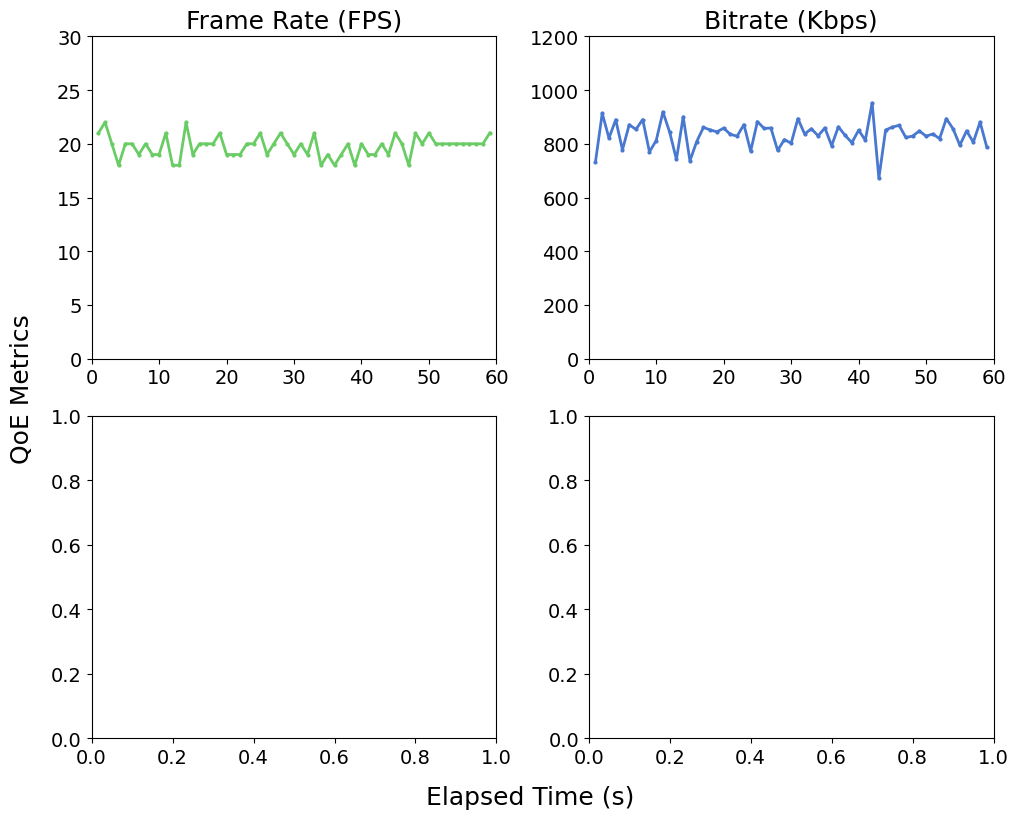

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

plot_rates(frame_rates, window, 30, "Frame Rate (FPS)", green, ax[0][0])
plot_rates(np.array(bit_rates) / 1000, window, 1200, "Bitrate (Kbps)", blue, ax[0][1])

fig.text(-0.02, 0.5, 'QoE Metrics', va='center', rotation='vertical', fontsize=18)
fig.text(0.5, -0.02, 'Elapsed Time (s)', ha='center', fontsize=18)

plt.tight_layout()
plt.show()

## Old Code

In [ ]:
interval = 1000
throughputs = []
starts = [x[0] + timedelta(milliseconds=i) for i in range(0, int((x[-1] - x[0]).total_seconds()*1000), interval)]
for t in starts:
    start_time = t
    end_time = t + timedelta(milliseconds=interval)
    bytes_in_interval = sum([length for timestamp, length in zip(x, y) if start_time <= timestamp < end_time])
    throughput_bps = bytes_in_interval / interval
    throughputs.append(throughput_bps)

fig, ax = plt.subplots()
elapsed = [(e - starts[0]).total_seconds() for e in starts]

ax.plot(elapsed, np.array(throughputs) / 1000 * 8, color=orange, linewidth=1.5)
ax.set_title("Throughput Per Second")
ax.set_xlabel("Time Elapsed (s)")
ax.set_ylabel("Throughput (Mbps)")

plt.xlim(0, elapsed[-1])
plt.tight_layout()
plt.show()

In [ ]:
interval = 10
bursts = []
starts = [x[0] + timedelta(milliseconds=i) for i in range(0, int((x[-1] - x[0]).total_seconds() * 1000), interval)]

for t in starts:
    start_time = t
    end_time = t + timedelta(milliseconds=interval)
    bytes_in_interval = sum([length for timestamp, length in zip(x, y) if start_time <= timestamp < end_time])
    bursts.append(bytes_in_interval)
    
num_bins = len(bursts)
buckets = np.arange(num_bins)
bin_edges = np.arange(num_bins + 1)

In [ ]:
df = pd.DataFrame({'Bursts': bursts}, index=np.arange(num_bins))

window_size = 250
rolling_mean = df['Bursts'].rolling(window=window_size).mean()
rolling_std = df['Bursts'].rolling(window=window_size).std()

fig, ax = plt.subplots()
ax.hist(buckets, bins=bin_edges, weights=bursts, label='Bursts (10ms)', align='left', color=orange)
plt.plot(rolling_mean.index, rolling_mean, color=blue, label='Rolling Mean')
plt.plot(rolling_std.index, rolling_std, color=green, label='Rolling Std')
ax.set_title("Bursts Breakdown")
ax.set_xlabel("Time Elapsed (10ms buckets)")
ax.set_ylabel("Burst Size (B)")
plt.legend()

plt.xlim(0, 1000)
plt.tight_layout()
plt.show()

In [ ]:
latencies = []

for i in range(len(x) - 1):
    time_difference = (x[i + 1] - x[i]).total_seconds()*1000
    latencies.append(time_difference)

elapsed = [(e - x[0]).total_seconds() for e in x]

In [ ]:
df = pd.DataFrame({'Latency': latencies}, index=elapsed[1:])
window_size = 500
rolling_mean = df['Latency'].rolling(window=window_size).mean()
rolling_std = df['Latency'].rolling(window=window_size).std()

fig, ax = plt.subplots()
plt.vlines(elapsed[1:][::33], ymin=0, ymax=latencies[::33], color=orange, label="Latency")
plt.plot(elapsed[1:], rolling_mean, color=blue, label='Rolling Mean')
plt.plot(elapsed[1:], rolling_std, color=green, label='Rolling Std')

plt.title("Packet Interval")

plt.xlabel("Time Elapsed (s)")
plt.ylabel("Latency (ms)")
plt.legend()

plt.xlim(0, elapsed[-1])
plt.ylim(0)
plt.tight_layout()
plt.show()

## 